In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
import os

In [4]:
import torch

In [5]:
import torchvision

In [6]:
torch.__version__

'2.2.0'

In [7]:
torch.cuda.is_available()

True

In [8]:
torchvision.__version__

'0.17.0'

In [9]:
!pip install pycocotools

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0.7-cp312-cp312-win_amd64.whl size=81631 sha256=044e48ff0479337e5801e5826bf4e87c9ff2a21f4270a97f35b93de53e7005ff
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\1e\b8\6d\646852bb348f96f4928351fc4b023cdace78cb8f43d2244ded
Successfully built pycocotools


In [10]:
os.system("curl https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py -O")
os.system("curl https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py -O")
os.system("curl https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py -O")
os.system("curl https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py -O")
os.system("curl https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py -O")

0

https://www.v7labs.com/blog/coco-dataset-guide

In [11]:
import json
from PIL import Image
from pycocotools.coco import COCO
import torch
from torchvision import transforms

class CustomCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        # Load the image
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        # Prepare target
        num_objs = len(coco_annotation)
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            areas.append(coco_annotation[i]['area'])
            iscrowd.append(coco_annotation[i]['iscrowd'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids)


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Instantiate your dataset
dataset = CustomCOCODataset(root='data/ktrain_sample/images', 
                            annotation='data/ktrain_sample/annotations/instances_default.json',
                            transform=transform)

# Test
print(len(dataset))
dataset[0]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2


(tensor([[[0.4784, 0.4941, 0.4863,  ..., 0.6157, 0.6078, 0.5882],
          [0.5059, 0.4980, 0.4902,  ..., 0.6000, 0.6000, 0.5961],
          [0.4784, 0.4824, 0.4902,  ..., 0.5961, 0.5961, 0.6078],
          ...,
          [0.7961, 0.8196, 0.8353,  ..., 0.7059, 0.7412, 0.7373],
          [0.7922, 0.8118, 0.8157,  ..., 0.6588, 0.6824, 0.6941],
          [0.4745, 0.5529, 0.8314,  ..., 0.6784, 0.6588, 0.6588]],
 
         [[0.6275, 0.6431, 0.6314,  ..., 0.7333, 0.7255, 0.7137],
          [0.6431, 0.6353, 0.6314,  ..., 0.7216, 0.7216, 0.7176],
          [0.6235, 0.6275, 0.6314,  ..., 0.7176, 0.7176, 0.7255],
          ...,
          [0.7098, 0.7255, 0.7373,  ..., 0.6157, 0.6549, 0.6549],
          [0.7176, 0.7255, 0.7176,  ..., 0.5804, 0.5961, 0.6078],
          [0.3961, 0.4667, 0.7255,  ..., 0.5922, 0.5686, 0.5647]],
 
         [[0.8471, 0.8549, 0.8471,  ..., 0.9098, 0.9059, 0.8941],
          [0.8588, 0.8549, 0.8510,  ..., 0.9020, 0.9020, 0.8980],
          [0.8431, 0.8431, 0.8510,  ...,

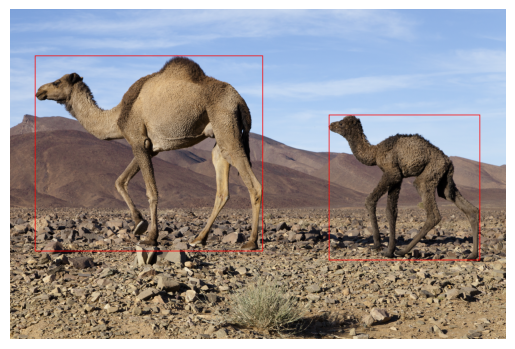

In [13]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import torchvision.utils as utils
import matplotlib.pyplot as plt

img, target = dataset[0]

# Convert the image to a tensor if it's not already
if not isinstance(img, torch.Tensor):
    img = F.to_tensor(img)

# Convert back to uint8 for drawing boxes
if img.dtype == torch.float32:
    img = (img * 255).type(torch.uint8)
    
# Draw the bounding boxes on the image
img_with_boxes = utils.draw_bounding_boxes(img, target['boxes'], width=3, colors='red')

# Convert the tensor to PIL Image for display
img_with_boxes = F.to_pil_image(img_with_boxes)

# Display the image
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()

In [14]:
import utils
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = CustomCOCODataset(root='data/ktrain_sample/images', 
                            annotation='data/ktrain_sample/annotations/instances_default.json',
                            transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    #num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\user/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:14<00:00, 11.2MB/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'loss_classifier': tensor(2.0495, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1626, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0045, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0096, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    #now get the number of input features for the mask classifier
    #in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    #hidden_layer = 256
    # and replace the mask predictor with a new one
    #model.roi_heads.mask_predictor = MaskRCNNPredictor(
    #    in_features_mask,
    #    hidden_layer,
    #    num_classes
    #)

    return model

In [16]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# use our dataset and defined transformations
dataset = CustomCOCODataset(root='data/ktrain_sample/images', 
                            annotation='data/ktrain_sample/annotations/instances_default.json',
                            transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    #shuffle=True,
    #num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [0/2]  eta: 0:00:12  lr: 0.005000  loss: 1.0513 (1.0513)  loss_classifier: 0.6189 (0.6189)  loss_box_reg: 0.4235 (0.4235)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 6.3220  data: 0.0781  max mem: 1332
Epoch: [0]  [1/2]  eta: 0:00:03  lr: 0.005000  loss: 1.0513 (1.3593)  loss_classifier: 0.6189 (0.6209)  loss_box_reg: 0.4235 (0.7243)  loss_objectness: 0.0040 (0.0045)  loss_rpn_box_reg: 0.0049 (0.0096)  time: 3.5400  data: 0.0859  max mem: 1489
Epoch: [0] Total time: 0:00:07 (3.5400 s / it)
Epoch: [1]  [0/2]  eta: 0:00:01  lr: 0.005000  loss: 0.5799 (0.5799)  loss_classifier: 0.2192 (0.2192)  loss_box_reg: 0.3541 (0.3541)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.7202  data: 0.0810  max mem: 1489
Epoch: [1]  [1/2]  eta: 0:00:00  lr: 0.005000  loss: 0.5799 (1.1227)  loss_classifier: 0.2192 (0.4666)  loss_box_reg: 0.3541 (0.6480

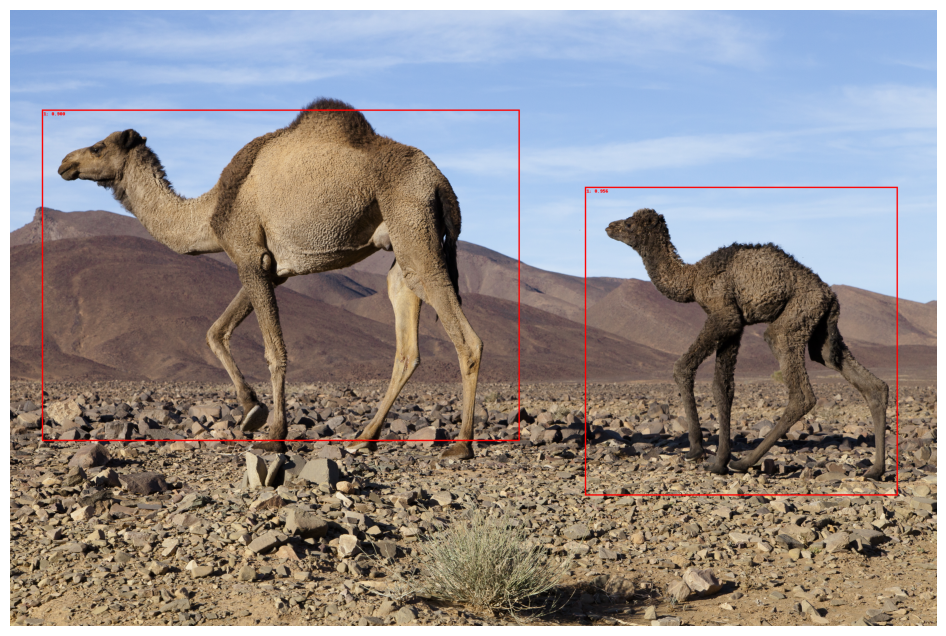

In [17]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import PILToTensor
from torchvision.io import read_image

image, targets = dataset[0]
model.eval()

with torch.no_grad():
    x = image.to(device)
    # convert RGBA -> RGB and move to device
    #x = x[0][:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Assuming 'pred' is your prediction dictionary from the model
high_confidence_threshold = 0.7
high_confidence_indices = [i for i, score in enumerate(pred["scores"]) if score >= high_confidence_threshold]

# Filter labels and boxes with scores >= 0.7
filtered_labels = [f"{pred['labels'][i]}: {pred['scores'][i]:.3f}" for i in high_confidence_indices]
filtered_boxes = pred["boxes"][high_confidence_indices].long()

# Draw bounding boxes
output_image = draw_bounding_boxes(image, filtered_boxes, labels=filtered_labels, width=3, colors="red")

# Display the image (assuming you're using matplotlib)
plt.figure(figsize=(12, 8))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')
plt.show()